# Few-Shot Learning Email Classification with Pre-Trained Word2Vec Embeddings

In [8]:
import pandas as pd
import numpy as np
from random import seed
from random import sample
from wordfile import func
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re
import joblib
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from scipy import spatial
import os
import spacy
import en_core_web_sm

In [2]:
embeddings_index = {}
with open('/home/aheli/glove.6B.300d.txt',encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:],dtype='float32')
        embeddings_index[word] = coeffs
    f.close()

In [3]:
# from google.colab import files
# uploaded = files.upload()

In [4]:
df = pd.read_csv("/home/aheli/SmartEmailTracker/Merged UI_Listener/emaildataset.csv", usecols = ['Subject','Body', 'Class'])

In [5]:
df.head(50)

,Subject,Body,Class
0,Transaction no. 072558 is unresolved.,Sorry to inform that there has been only a par...,Pending
1,Order for new Cheque book,"Good morning, I want to place an order for an ...",General
2,Required money acquired. Transaction 847047 is...,Hello! This is to inform you that I have recei...,Processing
3,Asking for the details for transaction 746078,I request you to kindly send the status of my ...,Request
4,Partial payment for transaction 535918,Hello!! Greetings for the day. Status of trans...,Pending
5,Payment done and Transaction 683241 settled.,Greetings! I wanted to let you know that I hav...,Complete
6,Failure of transaction 608189,This is to notify you that my transaction 6081...,Failed
7,Send steps to activate online banking,"Hey, I have to transfer funds to a different b...",General
8,Incomplete transaction 947071,I regret to inform you that I could only pay t...,Pending
9,Failure of transaction 443004,"Hey, I see my transaction with ID 443004 has f...",Failed


In [6]:
nlp = spacy.load('en')

In [9]:
nlp_ = en_core_web_sm.load()

In [10]:
my_stop = ["'d", "'ll", "'m", "'re", "'s", "'ve",'a','cc','subject','http', 'gbp', 'usd', 'eur', 'inr', 'cad', 'thanks', "acc", "id", 'account', 'regards', 'hi', 'hello', 'thank you', 'greetings', 'about','above', 'across','after','afterwards','alone','along','am','among', 'amongst','amount','an','and','another','any','anyhow','anyone','anything','anyway','anywhere','are','around','as', 'at','be','became','because','become','becomes','becoming','been','before','beforehand','behind','being','below', 'beside','besides','between','both','bottom','but','by','ca','call','can','could','did', 'do', 'does', 'doing', 'down', 'due', 'during', 'each', 'eight', 'either', 'eleven', 'else', 'elsewhere', 'everyone', 'everything', 'everywhere', 'fifteen', 'fifty', 'first', 'five', 'for', 'former', 'formerly', 'forty', 'four', 'from', 'front', 'further', 'get', 'give', 'go', 'had', 'has', 'have', 'he', 'hence', 'her', 'here', 'hereafter', 'hereby', 'herein', 'hereupon', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'however', 'hundred', 'i', 'if', 'in', 'indeed', 'into', 'is', 'it', 'its', 'itself', 'just', 'keep', 'last', 'latter', 'latterly', 'least', 'less', 'made', 'make', 'many', 'may', 'me', 'meanwhile', 'might', 'mine', 'more', 'moreover', 'move', 'much', 'must', 'my', 'myself', 'name', 'namely', 'neither', 'nevertheless', 'next', 'nine', 'no', 'nobody', 'now', 'nowhere', 'of', 'off', 'often', 'on', 'one', 'onto', 'or', 'other', 'others', 'otherwise', 'our', 'ours', 'ourselves', 'out', 'own', 'part', 'per', 'perhaps', 'please', 'put', 'quite', 'rather', 're', 'really', 'regarding', 'same', 'say', 'see', 'seem', 'seemed', 'seeming', 'seems', 'she', 'should', 'show', 'side', 'since', 'six', 'sixty', 'so', 'some', 'somehow', 'someone', 'something', 'sometime', 'somewhere', 'such', 'take', 'ten', 'than', 'that', 'the', 'their', 'them', 'themselves', 'then', 'thence', 'there', 'thereafter', 'thereby', 'therefore', 'therein', 'thereupon', 'these', 'they', 'third', 'this', 'those', 'three', 'through', 'throughout', 'thru', 'thus', 'to', 'together', 'too', 'top', 'toward', 'towards', 'twelve', 'twenty', 'two', 'under', 'up', 'upon', 'us', 'using', 'various', 'via', 'was', 'we', 'well', 'were', 'whatever', 'whence', 'whenever', 'whereafter', 'whereas', 'whereby', 'wherein', 'whereupon', 'wherever', 'whether', 'which', 'while', 'whither', 'whoever', 'whole', 'whom', 'whose', 'will', 'with', 'within', 'would', 'yet', 'you', 'your', 'yours', 'yourself', 'yourselves', '‘d', '‘ll', '‘m', '‘re', '‘s', '‘ve', '’d', '’ll', '’m', '’re', '’s', '’ve']


In [11]:
def get_only_chars(text):    
    text = text.replace("-", " ") #replace hyphens with spaces
    text = text.replace("\t", " ")
    text = text.replace("\n", " ")

    text=text.rstrip()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    t = ""

    for i in text.lower().split():
        if func(i) is not None:
            t += func(i) + " "
        else :
            t += i + " "

    t = t.rstrip()
    
    text = " ".join([i for i in t.lower().split()])
    text = " ".join(token for token in text.split() if token not in my_stop)

#     doc = nlp(text)
    
#     *****
    doc = nlp(text)
    
    normalized = " ".join(token.lemma_ for token in doc)
    
    doc = " ".join(token.orth_ for token in nlp(normalized) if not token.is_punct | token.is_space)

    return doc
#     *****
    
#     doc = " ".join(token.orth_ for token in doc if not token.is_punct | token.is_space)
#     return doc

In [12]:
print(get_only_chars("hi i want info on le 12234."))

want info legal entity


In [13]:
for i in range(df.shape[0]):
    # merge subject and body strings
    df['Text'] = (df['Subject'] + " " + df['Body'])

In [14]:
def converter(x):
    try:
        return ' '.join([x.lower() for x in str(x).split()])
    except AttributeError:
        return None  # or some other value

df['Text'] = df['Text'].apply(converter)

In [15]:
# text_clean=[]

# for i in range(df.shape[0]):
#     text_clean.append(get_only_chars(df.loc[i]['Text']))

In [16]:
df['Text'] = df['Text'].apply(lambda x: get_only_chars(x))

In [17]:
df = df.drop_duplicates('Text')

In [18]:
df.shape

(354, 4)

In [19]:
df.sample(frac=1).reset_index(drop=True)

,Subject,Body,Class,Text
0,Payment is pending for transaction 022539,It's been 10 days since transaction 022539 . I...,Pending,payment pende transaction s day transaction ve...
1,Pending payment for transaction having ID : 46...,"Hey, sincere apologies for transferring a frac...",Pending,pende payment transaction have hey sincere apo...
2,Soliciting information for ID : 696876,Urgently require details of acc 696876 reply asap,Request,solicit information urgently require detail re...
3,Payment received for transaction : 130956 and ...,Hello! This is to inform you that I have recei...,Processing,payment receive transaction processing inform ...
4,Failure of transaction 443004,"Hey, I see my transaction with ID 443004 has f...",Failed,failure transaction hey transaction fail think...
...,...,...,...,...
349,Create a new bank account,"Hey, Can you please send me the detailed steps...",General,create new bank hey send detailed step ought f...
350,Asking for the details for transaction 573115,"Kindly note that this is urgent, I need detail...",Request,ask detail transaction kindly note urgent need...
351,Request to send details of transaction 879899,"I need details of 879899 urgently, please prov...",Request,request send detail transaction need detail ur...
352,Dealing with the transaction 807909,Acknowledging the received payment for transac...,Processing,deal transaction acknowledge receive payment t...


In [20]:
# set the by default to:
num_classes = df.Class.unique() # the number of classes we consider (since the dataset has many classes)
sample_size = 5 # the number of labeled sampled we’ll require from the user

In [21]:
smallest_sample_size = min(df['Class'].value_counts())

In [22]:
# Generate samples that contains K samples of each class

def gen_sample(sample_size, num_classes, df):
    
#     df = df.sample(frac=1).reset_index(drop=True)

    df_1 = df[(df["Class"] < num_classes+1)].reset_index().drop(["index"], axis=1).reset_index().drop(["index"], axis=1)
    
    train = df_1[df_1["Class"] == np.unique(df_1['Class'])[0]].sample(sample_size)
    train_index = train.index.tolist()

    for i in range(1,num_classes):
        train_2 = df_1[df_1["Class"] == np.unique(df_1['Class'])[i]].sample(sample_size)
        train = pd.concat([train, train_2], axis=0)
        train_index.extend(train_2.index.tolist())

    test = df_1[~df_1.index.isin(train_index)]
    return train, test

In [23]:
from sklearn.preprocessing import LabelEncoder 

le = LabelEncoder()
df['Class'] = le.fit_transform(df['Class'])

In [24]:
df.head(20)

,Subject,Body,Class,Text
0,Transaction no. 072558 is unresolved.,Sorry to inform that there has been only a par...,3,transaction unresolve sorry inform only partia...
1,Order for new Cheque book,"Good morning, I want to place an order for an ...",2,order new cheque book good morning want place ...
2,Required money acquired. Transaction 847047 is...,Hello! This is to inform you that I have recei...,4,require money acquire transaction process info...
3,Asking for the details for transaction 746078,I request you to kindly send the status of my ...,5,ask detail transaction request kindly send sta...
4,Partial payment for transaction 535918,Hello!! Greetings for the day. Status of trans...,3,partial payment transaction day status transac...
5,Payment done and Transaction 683241 settled.,Greetings! I wanted to let you know that I hav...,0,payment do transaction settle want let know ac...
6,Failure of transaction 608189,This is to notify you that my transaction 6081...,1,failure transaction notify transaction fail re...
7,Send steps to activate online banking,"Hey, I have to transfer funds to a different b...",2,send step activate online banking hey transfer...
8,Incomplete transaction 947071,I regret to inform you that I could only pay t...,3,incomplete transaction regret inform only pay ...
9,Failure of transaction 443004,"Hey, I see my transaction with ID 443004 has f...",1,failure transaction hey transaction fail think...


In [25]:
df.Class.value_counts()

2    75
5    72
3    66
0    51
1    49
4    41
Name: Class, dtype: int64

In [26]:
for i in range(0, 6):
    print(i)
    print(le.inverse_transform([i]))

0
['Complete']
1
['Failed']
2
['General']
3
['Pending']
4
['Processing']
5
['Request']


In [27]:
train, test = gen_sample(25, 6, df)

In [28]:
train.Class.value_counts()

5    25
4    25
3    25
2    25
1    25
0    25
Name: Class, dtype: int64

In [29]:
test.Class.value_counts()

2    50
5    47
3    41
0    26
1    24
4    16
Name: Class, dtype: int64

In [30]:
def transform_sentence(text, embeddings_index):

    def preprocess_text(raw_text, model=embeddings_index):

        raw_text = raw_text.split()
        return list(filter(lambda x: x in embeddings_index.keys(), raw_text))

    tokens = preprocess_text(text)

    if not tokens:
        return np.zeros(300)

    c = [embeddings_index[i] for i in tokens]
    text_vector = np.mean(c, axis=0)
    return np.array(text_vector)

In [32]:
if not os.path.exists('/home/aheli/SmartEmailTracker/Merged UI_Listener/pkl_objects'):
        os.mkdir('/home/aheli/SmartEmailTracker/Merged UI_Listener/pkl_objects')
    
joblib.dump(le, '/home/aheli/SmartEmailTracker/Merged UI_Listener/pkl_objects/labelencoder.pkl')

['/home/aheli/SmartEmailTracker/Merged UI_Listener/pkl_objects/labelencoder.pkl']

## Pre-trained Glove embeddings and ML algorithms

In [33]:
# Install with below cell if you're not able to install on terminal

# import sys
# !{sys.executable} -m pip install xgboost

In [34]:
import xgboost

In [47]:
def return_score_xgb(sample_size, num_classes, df):

    train, test = gen_sample(sample_size, num_classes, df=df)

    X_train = train['Text'].values
    y_train = train['Class'].values
    X_test = test['Text'].values
    y_test = test['Class'].values

    X_train_mean = np.array([transform_sentence(x, embeddings_index) for x in X_train])
    X_test_mean = np.array([transform_sentence(x, embeddings_index) for x in X_test])

#     XG Boost
    clf = xgboost.XGBClassifier()
    
    eval_set = [(X_train_mean, y_train), (X_test_mean, y_test)]
    eval_metric = ["auc","error", "logloss"]
    %time clf.fit(X_train_mean, y_train, early_stopping_rounds=10, eval_metric="merror", eval_set=eval_set, verbose=True)
#     clf.fit(X_train_mean, y_train)

    joblib.dump(clf, './clf.pkl')

    y_pred = clf.predict(X_test_mean)
    
    # evaluate predictions
    accuracy = accuracy_score(y_pred, y_test)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))

    return accuracy_score(y_pred, y_test)

## Comparison of accuracies

In [48]:
all_accuracy = {0: []}

for num_samples in range(1, 26):
    all_accuracy[0].append(return_score_xgb(num_samples,len(df.Class.unique()), df))

[0]	validation_0-merror:0.83333	validation_1-merror:0.85632
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 10 rounds.
[1]	validation_0-merror:0.83333	validation_1-merror:0.85632
[2]	validation_0-merror:0.83333	validation_1-merror:0.85632
[3]	validation_0-merror:0.83333	validation_1-merror:0.85632
[4]	validation_0-merror:0.83333	validation_1-merror:0.85632
[5]	validation_0-merror:0.83333	validation_1-merror:0.85632
[6]	validation_0-merror:0.83333	validation_1-merror:0.85632
[7]	validation_0-merror:0.83333	validation_1-merror:0.85632
[8]	validation_0-merror:0.83333	validation_1-merror:0.85632
[9]	validation_0-merror:0.83333	validation_1-merror:0.85632
[10]	validation_0-merror:0.83333	validation_1-merror:0.85632
Stopping. Best iteration:
[0]	validation_0-merror:0.83333	validation_1-merror:0.85632

CPU times: user 509 ms, sys: 30.2 ms, total: 540 ms
Wall time: 293 ms
Accuracy: 14.37%
[0

[15]	validation_0-merror:0.00000	validation_1-merror:0.34591
[16]	validation_0-merror:0.00000	validation_1-merror:0.34591
[17]	validation_0-merror:0.00000	validation_1-merror:0.34591
[18]	validation_0-merror:0.00000	validation_1-merror:0.34591
[19]	validation_0-merror:0.00000	validation_1-merror:0.34591
[20]	validation_0-merror:0.00000	validation_1-merror:0.34591
[21]	validation_0-merror:0.00000	validation_1-merror:0.34591
[22]	validation_0-merror:0.00000	validation_1-merror:0.34591
Stopping. Best iteration:
[12]	validation_0-merror:0.00000	validation_1-merror:0.34591

CPU times: user 1.15 s, sys: 64.2 ms, total: 1.22 s
Wall time: 644 ms
Accuracy: 65.41%
[0]	validation_0-merror:0.04762	validation_1-merror:0.41346
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 10 rounds.
[1]	validation_0-merror:0.02381	validation_1-merror:0.34936
[2]	validation_0-merror:0.02381	validation_1-merror:0.

[11]	validation_0-merror:0.00000	validation_1-merror:0.27551
[12]	validation_0-merror:0.00000	validation_1-merror:0.27551
[13]	validation_0-merror:0.00000	validation_1-merror:0.26531
[14]	validation_0-merror:0.00000	validation_1-merror:0.26531
[15]	validation_0-merror:0.00000	validation_1-merror:0.25850
[16]	validation_0-merror:0.00000	validation_1-merror:0.24830
[17]	validation_0-merror:0.00000	validation_1-merror:0.24490
[18]	validation_0-merror:0.00000	validation_1-merror:0.26190
[19]	validation_0-merror:0.00000	validation_1-merror:0.25850
[20]	validation_0-merror:0.00000	validation_1-merror:0.25850
[21]	validation_0-merror:0.00000	validation_1-merror:0.25850
[22]	validation_0-merror:0.00000	validation_1-merror:0.25850
[23]	validation_0-merror:0.00000	validation_1-merror:0.26190
[24]	validation_0-merror:0.00000	validation_1-merror:0.26190
[25]	validation_0-merror:0.00000	validation_1-merror:0.26190
[26]	validation_0-merror:0.00000	validation_1-merror:0.26190
[27]	validation_0-merror

[3]	validation_0-merror:0.00000	validation_1-merror:0.16667
[4]	validation_0-merror:0.00000	validation_1-merror:0.15926
[5]	validation_0-merror:0.00000	validation_1-merror:0.16667
[6]	validation_0-merror:0.00000	validation_1-merror:0.14074
[7]	validation_0-merror:0.00000	validation_1-merror:0.15185
[8]	validation_0-merror:0.00000	validation_1-merror:0.14074
[9]	validation_0-merror:0.00000	validation_1-merror:0.14074
[10]	validation_0-merror:0.00000	validation_1-merror:0.13333
[11]	validation_0-merror:0.00000	validation_1-merror:0.12593
[12]	validation_0-merror:0.00000	validation_1-merror:0.12222
[13]	validation_0-merror:0.00000	validation_1-merror:0.12593
[14]	validation_0-merror:0.00000	validation_1-merror:0.12593
[15]	validation_0-merror:0.00000	validation_1-merror:0.12222
[16]	validation_0-merror:0.00000	validation_1-merror:0.11482
[17]	validation_0-merror:0.00000	validation_1-merror:0.11482
[18]	validation_0-merror:0.00000	validation_1-merror:0.11111
[19]	validation_0-merror:0.0000

[19]	validation_0-merror:0.00000	validation_1-merror:0.10318
[20]	validation_0-merror:0.00000	validation_1-merror:0.09921
[21]	validation_0-merror:0.00000	validation_1-merror:0.09921
[22]	validation_0-merror:0.00000	validation_1-merror:0.09921
[23]	validation_0-merror:0.00000	validation_1-merror:0.09524
[24]	validation_0-merror:0.00000	validation_1-merror:0.08730
[25]	validation_0-merror:0.00000	validation_1-merror:0.08730
[26]	validation_0-merror:0.00000	validation_1-merror:0.08730
[27]	validation_0-merror:0.00000	validation_1-merror:0.08730
[28]	validation_0-merror:0.00000	validation_1-merror:0.08730
[29]	validation_0-merror:0.00000	validation_1-merror:0.08730
[30]	validation_0-merror:0.00000	validation_1-merror:0.08730
[31]	validation_0-merror:0.00000	validation_1-merror:0.08730
[32]	validation_0-merror:0.00000	validation_1-merror:0.08730
[33]	validation_0-merror:0.00000	validation_1-merror:0.08730
[34]	validation_0-merror:0.00000	validation_1-merror:0.08730
Stopping. Best iteration

Stopping. Best iteration:
[1]	validation_0-merror:0.00000	validation_1-merror:0.11403

CPU times: user 1.25 s, sys: 46.3 ms, total: 1.29 s
Wall time: 553 ms
Accuracy: 88.60%
[0]	validation_0-merror:0.01515	validation_1-merror:0.20721
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 10 rounds.
[1]	validation_0-merror:0.00000	validation_1-merror:0.14865
[2]	validation_0-merror:0.00000	validation_1-merror:0.12613
[3]	validation_0-merror:0.00000	validation_1-merror:0.10360
[4]	validation_0-merror:0.00000	validation_1-merror:0.09009
[5]	validation_0-merror:0.00000	validation_1-merror:0.08559
[6]	validation_0-merror:0.00000	validation_1-merror:0.07207
[7]	validation_0-merror:0.00000	validation_1-merror:0.06757
[8]	validation_0-merror:0.00000	validation_1-merror:0.06757
[9]	validation_0-merror:0.00000	validation_1-merror:0.07207
[10]	validation_0-merror:0.00000	validation_1-merror:0.06757
[1

No handles with labels found to put in legend.


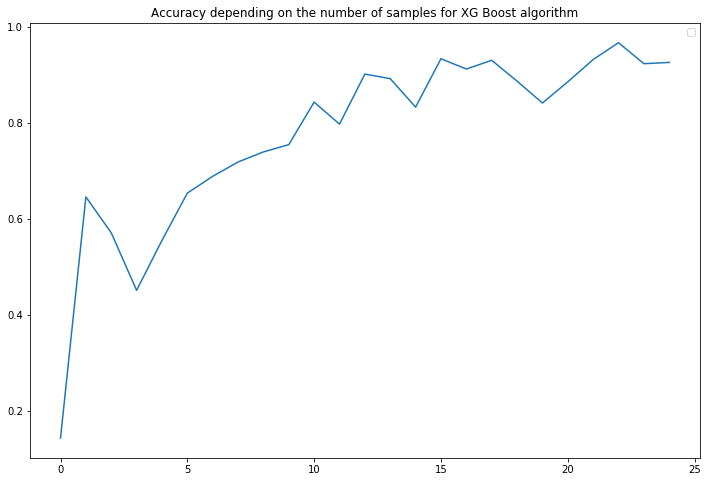

In [49]:
plt.figure(figsize=(12,8))
plt.plot(all_accuracy[0])
# plt.axvline(7, c='black', alpha=0.5)

plt.title("Accuracy depending on the number of samples for XG Boost algorithm")
plt.legend()
plt.show()

## Summary

In [50]:
df_results = pd.DataFrame({
    
    'Nb Classes':[6], 

    'mean XG Boost':[np.mean(all_accuracy[0])], 
    'max XG Boost':[
        max(all_accuracy[0])]
    })

df_results

,Nb Classes,mean XG Boost,max XG Boost
0,6,0.773548,0.967593


In [ ]:
def return_score(sample_size, num_classes, df):

    train, test = gen_sample(sample_size, num_classes, df=df)

    X_train = train['Text'].values
    y_train = train['Class'].values
    X_test = test['Text'].values
    y_test = test['Class'].values

    X_train_mean = np.array([transform_sentence(x, embeddings_index) for x in X_train])
    X_test_mean = np.array([transform_sentence(x, embeddings_index) for x in X_test])

#     XG Boost
    clf2 = xgboost.XGBClassifier()
    
    eval_set = [(X_train_mean, y_train), (X_test_mean, y_test)]
#     eval_metric = ["auc","error", "logloss"]
    clf2.fit(X_train_mean, y_train, early_stopping_rounds=10, eval_metric="merror", eval_set=eval_set, verbose=True)
    

    joblib.dump(clf, './clf_multi.pkl')

    y_pred = clf2.predict(X_test_mean)
    
    # evaluate predictions
    accuracy = accuracy_score(y_pred, y_test)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))

    return accuracy_score(y_pred, y_test)

In [ ]:
all_accuracy_xgb = {num:[] for num in range(2, len(df.Class.unique()) + 1)}

In [ ]:
for num_samples in range(1, 40):

    for num_cl in range(2, len(df.Class.unique()) + 1):

        all_accuracy_xgb[num_cl].append(return_score_xgb(num_samples,num_cl, df))

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(all_accuracy_xgb[2], label="2 classes")
plt.plot(all_accuracy_xgb[3], label="3 classes")
plt.plot(all_accuracy_xgb[4], label="4 classes")
plt.plot(all_accuracy_xgb[5], label="5 classes")
plt.plot(all_accuracy_xgb[6], label="6 classes")
plt.axvline(7, c='black', alpha=0.5)

plt.title("Accuracy depending on the number of classes for XG Boost algorithm")
plt.legend()
plt.show()
plt.savefig('accuracy_plot.jpg')

In [ ]:
df_results = pd.DataFrame({
    
    'Nb Classes':[2, 3, 4, 5, 6], 

    'mean XG Boost':[np.mean(all_accuracy_xgb[2]), 
        np.mean(all_accuracy_xgb[3]), 
        np.mean(all_accuracy_xgb[4]), 
        np.mean(all_accuracy_xgb[5]),
        np.mean(all_accuracy_xgb[6])],
    'max XG Boost':[max(all_accuracy_xgb[2]), 
        max(all_accuracy_xgb[3]), 
        max(all_accuracy_xgb[4]), 
        max(all_accuracy_xgb[5]),
        max(all_accuracy_xgb[6])]
    })

In [ ]:
df_results

## Testing on incoming email 

In [51]:
le = joblib.load('/home/aheli/SmartEmailTracker/Merged UI_Listener/pkl_objects/labelencoder.pkl')
clf = joblib.load('./clf.pkl')

In [40]:
def is_empty_sent(cd):
#     for i in range(cd.shape[0]):
#         if cd[i] != 0:
#             return False
#     return True
    all_zeros = not cd.any()
    return all_zeros

print(is_empty_sent(transform_sentence("efrg vftrg ojinc", embeddings_index)))

True


In [52]:
def inp(emailto, emailfrom, subj, bod):
    text = subj + " " + bod
    text = get_only_chars(text)
    X_test_mean = np.array([transform_sentence(text, embeddings_index)])
    
    if is_empty_sent(X_test_mean) is True:
        print("Unable to read email.Please ensure that it is in English!")
        return

    y_pred = clf.predict(X_test_mean)
    print(y_pred)

    return le.inverse_transform(y_pred)

In [53]:
print(inp("fvf", "defrfg", "payment processed", "hi, the payment for acc 1234 for usd 3456 was paid successfully."))

[4]
['Processing']


In [54]:
print(inp("cfdfv", "derftrg", "Partially paid the required amount for transaction", "There has been only a partial payment of amount 1234"))

[3]
['Pending']


In [55]:
print(inp("Jason@DEUTSCHEBANK.com", "Suhail@CitiBankPune.com", "Want to know more about being a premium customer", "Sincere greetings. I recently came across an offer saying I would have higher interest rates if I am willing to upgrade my account to a premium one. I want to base my decision on its pros as well as cons. So perhaps you could throw some light on it? That woud be very kind of you."))

[2]
['General']


In [56]:
print(inp("qwrqef", "cfdvfv", "", "Payment of 471862128 CAD to account id 101165 has been made on 19/02/2020 and is in progress, please acknowledge."))

[1]
['Failed']


In [57]:
print(inp("RFg", "ewrdef", "what is the status of my transaction: 12345", "hello "))

[3]
['Pending']


In [58]:
print(inp("abdf@", "fvfb","payment for ID 3456 done", "I'm glad to inform you that your payment was successfully transferred to the bank account."))

[0]
['Complete']
